In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log, square, sqrt, power, arange, ones, zeros, isscalar,\
    array, outer, pi, sin, cos, expand_dims, repeat, full, concatenate, ravel
from numpy.random import normal
from scipy.optimize import least_squares, minimize
%matplotlib inline

In [240]:
# Trade data

stock_name = 'AAPL.O'

df = pd.read_csv('NSQ_OneYear100test_Sept21.csv', 
                   usecols=['Local_Date_Time','RIC','Open','High','Low','Close','VWAP','NumberOfTrades','Volume'],
                   dtype={'Local_Date_Time': str,
                          'RIC': str, 
                          'Open': np.float64,
                          'High': np.float64,
                          'Low': np.float64,
                          'Close': np.float64,
                          'VWAP': np.float64,
                          'NumberOfTrades': int,
                          'Volume': int},
                   skipinitialspace=True,
                   parse_dates=True)
apple = df[df['RIC'] == stock_name]
apple['Date'] = pd.to_datetime(apple['Local_Date_Time']).dt.date

qqq = pd.read_csv('QQQ_OneYear100test_Sept21.csv', 
                   usecols=['Local_Date_Time','RIC','Open','High','Low','Close','VWAP','NumberOfTrades','Volume'],
                   dtype={'Local_Date_Time': str,
                          'RIC': str, 
                          'Open': np.float64,
                          'High': np.float64,
                          'Low': np.float64,
                          'Close': np.float64,
                          'VWAP': np.float64,
                          'NumberOfTrades': int,
                          'Volume': int},
                   skipinitialspace=True,
                   parse_dates=True)
qqq['Date'] = pd.to_datetime(qqq['Local_Date_Time']).dt.date

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [241]:
# Auction price data
auction = pd.read_csv('NSQ_OneYear100closeA_Sept21.csv',
                      skipinitialspace=True,
                      parse_dates=True)
apple_auction = auction[auction['RIC'] == stock_name]
apple_auction['Date'] = pd.to_datetime(apple_auction['Local_Date_Time']).dt.date

auction_qqq = pd.read_csv('QQQ_OneYear100closeA_Sept21.csv',
                      skipinitialspace=True,
                      parse_dates=True)
auction_qqq['Date'] = pd.to_datetime(auction_qqq['Local_Date_Time']).dt.date

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [242]:
# Data Processing (10 minute intervals)

dates = apple['Date'].unique()
dates_final = []
stocks = []
daily_return = []
auction_log_returns = []
auction_log_returns_340350 = []
daily_volatility = []
daily_volatility_minus4pm = []
avg_20day_volatility = []

for date in dates:
    
    apple_today = apple[apple['Date'] == date]
    apple_auction_today = apple_auction[apple_auction['Date'] == date]
    apple_today = apple_today.set_index(pd.DatetimeIndex(apple_today['Local_Date_Time']))
    apple_today_10min_max = pd.DataFrame(apple_today['High'].resample("10T").max())
    apple_today_10min_min = pd.DataFrame(apple_today['Low'].resample("10T").min())
    apple_today_10min_open = pd.DataFrame(apple_today['Open'].resample("10T").first())
    apple_today_10min_close = pd.DataFrame(apple_today['Close'].resample("10T").last())
    apple_today_10min = apple_today_10min_max.join(apple_today_10min_min)
    apple_today_10min = apple_today_10min.join(apple_today_10min_open)
    apple_today_10min = apple_today_10min.join(apple_today_10min_close)
    
    # Garman and Klass Volatility formula
    apple_today_10min['Volatility'] = np.sqrt(0.5*np.square(np.log(apple_today_10min['High']/apple_today_10min['Low'])) - (2*np.log(2)-1)*np.square(np.log(apple_today_10min['Close']/apple_today_10min['Open'])))
#     apple_today_10min['log_returns'] = abs(np.log(apple_today_10min['Close']/apple_today_10min['Open'])) # alternate volatility formula
    
    volatility_today = [val for val in apple_today_10min['Volatility'].values]
    return_today = (apple_today_10min['Close']/apple_today_10min['Open']).values
    
    if len(volatility_today) != 39: # Skip if there are fewer than 390 minutes of trading data
        continue
        
    # Dates for which the trade data is complete
    dates_final.append(date)
    
    # Change the 39th 10min interval to include the auction price (instead of close)
    auction_volatility = np.sqrt(0.5*np.square(np.log(apple_today_10min['High'][-1]/apple_today_10min['Low'][-1])) - (2*np.log(2)-1)*np.square(np.log(apple_auction_today['Price'].iloc[0]/apple_today_10min['Open'][-1])))
    volatility_today[-1] = auction_volatility
    
    # 10 minute interval volatility * number of complete trade days
    stocks.append(volatility_today)
    
    # Daily raw return
    daily_return.append(return_today)
        
    # Auction Volatility Information
    auction_log_returns_today = abs(np.log(apple_auction_today['Price'].iloc[0]/apple_today_10min['Open'][-1]))
    auction_log_returns.append(auction_log_returns_today)
    
    # Naive Auction Volatility Estimate (Volatility between 3:40pm and 3:50pm)
    auction_log_returns_today_340350 = abs(np.log(apple_today_10min['Open'][-1]/apple_today_10min['Open'][-2]))
    auction_log_returns_340350.append(auction_log_returns_today_340350)
    
    # Average daily volatility (later used for EWMA 20Day)
    daily_volatility.append(sum(volatility_today))
    daily_volatility_minus4pm.append(sum(volatility_today[:-1]))

daily_return = np.array(daily_return)
volatility_df = pd.DataFrame({'Date':dates_final, 'daily_volatility': daily_volatility, 'daily_volatility_minus4pm': daily_volatility_minus4pm})
volatility_df['volatility_ewma20'] = np.array([None] + [i for i in volatility_df['daily_volatility'].ewm(span=20).mean()][:-1])

stocks = stocks[20:]
stocks = np.vstack(stocks).T # Training data for Anderson model
avg_20day_volatility_raw = np.array(volatility_df['volatility_ewma20'])
avg_20day_volatility = np.array(volatility_df['volatility_ewma20'][20:]) # Sigma_t input for Anderson model

stocks200 = stocks.T
stocks200 = stocks200[:200].T
avg_20day_volatility200 = avg_20day_volatility[:200]


In [243]:
# # Data Processing (10 minute intervals)

# dates_qqq = qqq['Date'].unique()
# dates_final_qqq = []
# stocks_qqq = []
# daily_return_qqq = []
# auction_log_returns_qqq = []
# auction_log_returns_340350_qqq = []
# daily_volatility_qqq = []
# daily_volatility_minus4pm_qqq = []
# # daily_volatility2_qqq = []
# # daily_volatility2_minus4pm_qqq = []
# avg_20day_volatility_qqq = []

# for date in dates_qqq:
    
#     qqq_today = qqq[qqq['Date'] == date]
#     qqq_auction_today = auction_qqq[auction_qqq['Date'] == date]
#     qqq_today = qqq_today.set_index(pd.DatetimeIndex(qqq_today['Local_Date_Time']))
#     qqq_today_10min_max = pd.DataFrame(qqq_today['High'].resample("10T").max())
#     qqq_today_10min_min = pd.DataFrame(qqq_today['Low'].resample("10T").min())
#     qqq_today_10min_open = pd.DataFrame(qqq_today['Open'].resample("10T").first())
#     qqq_today_10min_close = pd.DataFrame(qqq_today['Close'].resample("10T").last())
#     qqq_today_10min = qqq_today_10min_max.join(qqq_today_10min_min)
#     qqq_today_10min = qqq_today_10min.join(qqq_today_10min_open)
#     qqq_today_10min = qqq_today_10min.join(qqq_today_10min_close)
    
#     # Garman and Klass Volatility formula
#     qqq_today_10min['Volatility'] = np.sqrt(0.5*np.square(np.log(qqq_today_10min['High']/qqq_today_10min['Low'])) - (2*np.log(2)-1)*np.square(np.log(qqq_today_10min['Close']/qqq_today_10min['Open'])))
# #     qqq_today_10min['log_returns'] = abs(np.log(qqq_today_10min['Close']/qqq_today_10min['Open'])) # alternate volatility formula
    
#     volatility_today_qqq = qqq_today_10min['Volatility'].values
#     return_today_qqq = (qqq_today_10min['Close']/qqq_today_10min['Open']).values
    
#     if len(volatility_today_qqq) != 39: # Skip if there are fewer than 390 minutes of trading data
#         continue
        
#     # Dates for which the trade data is complete
#     dates_final_qqq.append(date)
    
#     # Change the 39th 10min interval to include the auction price (instead of close)
#     auction_volatility_qqq = np.sqrt(0.5*np.square(np.log(qqq_today_10min['High'][-1]/qqq_today_10min['Low'][-1])) - (2*np.log(2)-1)*np.square(np.log(qqq_auction_today['Price'].iloc[0]/qqq_today_10min['Open'][-1])))
#     volatility_today_qqq[-1] = auction_volatility_qqq
    
#     # 10 minute interval volatility * number of complete trade days
#     stocks_qqq.append(volatility_today_qqq)
    
#     # Daily raw return
#     daily_return_qqq.append(return_today_qqq)
        
#     # Auction Volatility Information
#     auction_log_returns_today_qqq = abs(np.log(qqq_auction_today['Price'].iloc[0]/qqq_today_10min['Open'][-1]))
#     auction_log_returns_qqq.append(auction_log_returns_today_qqq)
    
#     # Naive Auction Volatility Estimate (Volatility between 3:40pm and 3:50pm)
#     auction_log_returns_today_340350_qqq = abs(np.log(qqq_today_10min['Open'][-1]/qqq_today_10min['Open'][-2]))
#     auction_log_returns_340350_qqq.append(auction_log_returns_today_340350_qqq)
    
#     # Average daily volatility (later used for EWMA 20Day)
#     daily_volatility_qqq.append(sum(volatility_today_qqq))
#     daily_volatility_minus4pm_qqq.append(sum(volatility_today_qqq[:-1]))
# #     daily_volatility2_qqq.append(np.sqrt(0.5*np.square(np.log(max(qqq_today_10min['High'])/min(qqq_today_10min['Low']))) - (2*np.log(2)-1)*np.square(np.log(qqq_today_10min['Close'][-1]/qqq_today_10min['Open'][0]))))
# #     daily_volatility2_minus4pm_qqq.append(np.sqrt(0.5*np.square(np.log(max(qqq_today_10min['High'][:-1])/min(qqq_today_10min['Low'][:-1]))) - (2*np.log(2)-1)*np.square(np.log(qqq_today_10min['Close'][-2]/qqq_today_10min['Open'][0]))))

# daily_return_qqq = np.array(daily_return_qqq)
# volatility_df_qqq = pd.DataFrame({'Date':dates_final_qqq, 'daily_volatility': daily_volatility_qqq, 'daily_volatility_minus4pm': daily_volatility_minus4pm_qqq})
# volatility_df_qqq['volatility_ewma20'] = np.array([None] + [i for i in volatility_df_qqq['daily_volatility'].ewm(span=20).mean()][:-1])

# stocks_qqq = stocks_qqq[20:]
# stocks_qqq = np.vstack(stocks_qqq).T # Training data for Anderson model
# avg_20day_volatility_raw_qqq = np.array(volatility_df_qqq['volatility_ewma20'])
# avg_20day_volatility_qqq = np.array(volatility_df_qqq['volatility_ewma20'][20:]) # Sigma_t input for Anderson model

# stocks_qqq = stocks_qqq.T
# stocks200_qqq = stocks_qqq[:200].T
# avg_20day_volatility200_qqq = avg_20day_volatility_qqq[:200]


In [223]:
# # Calculating beta for the stock (USE VOLATILITY TO VOLATILITY)
# daily_beta = []

# for i in range(251):
#     today_corr = np.corrcoef(daily_return[i][:-1], daily_return_qqq[i][:-1])[1][0]
#     today_beta = today_corr * np.sqrt(np.var(daily_return[i])) / np.sqrt(np.var(daily_return_qqq[i]))
#     daily_beta.append(today_beta)


In [224]:
# ########### FOURIER STOCK ###########

# fourier = flexible_fourier_regression(N=39, di=[], J=2, P=17) # 39 10-minute intervals in each trade day
# res = fourier.train(stocks200, avg_20day_volatility200, 0.0000005)
# print("optimizer success: {}".format(res.success))
# print("objective function (mse): {:.8f}".format(res.fun))

In [225]:
# n=230
# result = fourier.predict(avg_20day_volatility[n])

# fig, ax = plt.subplots(1, 1, figsize=(18, 8))
# ax.plot(stocks.T[n], label="actual")
# ax.plot(result, label="predicted")
# plt.xlabel("10 minute Time Interval")
# plt.ylabel("Absolute Log Returns")
# plt.title('Actual vs. Predicted Absolute Log Returns for MSFT on 2021-08-30')
# ax.legend()

In [226]:
# results = [None for i in range(20)]
# results_full = []

# for vol in avg_20day_volatility:
#     result = fourier.predict(vol)
#     results_full.append(np.array([res[0] for res in result]))
#     results.append(result[-1][0])
    
# results = np.array(results)
# results_full = np.array(results_full)

In [227]:
# actual = stocks.T[-31:,-1]
# predicted = np.array([fourier.predict(avg_20day_volatility[n])[-1][0] for n in range(200,231)])
# print(mean_absolute_error(actual, predicted))
# print(mean_squared_error(actual, predicted))
# print(r2_score(actual, predicted))

In [228]:
# plt.scatter(actual, predicted, alpha=0.5)
# # plt.xlim([0, 0.012])
# # plt.ylim([0, 0.012])
# plt.show()

In [229]:
# plt.plot(actual, label="actual")
# plt.plot(predicted, label="predicted")
# plt.legend()

In [230]:
# n=230

# # After Bayes
# bayes_dayVol = fourier.vol_update(stocks.T[n,:39], avg_20day_volatility[n], tol=1e-7)
# bayes_result = fourier.predict(bayes_dayVol)

# # Plot
# fig, ax = plt.subplots(1, 1, figsize=(18, 8))
# ax.plot(stocks.T[n], label="actual")
# ax.plot(results_full[n], label="pred")
# ax.plot(bayes_result, label="pred_bayes")
# plt.xlabel("10 minute Time Interval")
# plt.ylabel("Absolute Log Returns")
# plt.title('Actual vs. Predicted Absolute Log Returns for MSFT on 2021-08-30')
# ax.legend()

In [231]:
# from copy import deepcopy

# # Before Bayes
# fourier = flexible_fourier_regression(N=39, di=[], J=2, P=17) # 39 10-minute intervals in each trade day
# res = fourier.train(stocks200, avg_20day_volatility200, 0.0000005)
# predicted2 = []

# for n in range(200,231):

#     fourier_copy = deepcopy(fourier)

#     # After Bayes
#     bayes_dayVol = fourier_copy.vol_update(stocks.T[n,:39], avg_20day_volatility[n], tol=1e-7)
#     bayes_result = fourier_copy.predict(bayes_dayVol)
#     predicted2.append(bayes_result[-1][0])

# #     print(n)
# #     print('Before Bayes:', abs(stocks.T[n][-1] - results_full[n][-1]))
# #     print('After Bayes:', abs(stocks.T[n][-1] - bayes_result[-1]))
# #     print()

In [232]:
# print(mean_absolute_error(actual, predicted2))
# print(mean_squared_error(actual, predicted2))
# print(r2_score(actual, predicted2))

In [233]:
# plt.plot(actual, label="actual")
# plt.plot(predicted2, label="predicted")
# plt.legend()

In [234]:
# df_mod2C = pd.DataFrame()
# df_mod2C['Date'] = volatility_df['Date'][-32:]
# df_mod2C['daily_volatility'] = volatility_df['daily_volatility'][-32:]
# df_mod2C['daily_volatility_minus4pm'] = volatility_df['daily_volatility_minus4pm'][-32:]
# df_mod2C['auction'] = df_mod2C['daily_volatility'] - df_mod2C['daily_volatility_minus4pm']
# df_mod2C['daily_volatility_minus4pm_yest'] = df_mod2C['daily_volatility_minus4pm'].shift(1)
# df_mod2C['fourier_volatility_yest'] = np.array([None] + [val for val in predicted])
# df_mod2C['fourier_volatility_2c'] = df_mod2C['daily_volatility_minus4pm']/df_mod2C['daily_volatility_minus4pm_yest']*df_mod2C['fourier_volatility_yest']
# df_mod2C = df_mod2C[1:]
# df_mod2C

In [235]:
# predicted3 = df_mod2C['fourier_volatility_2c']

# print(mean_absolute_error(actual, predicted3))
# print(mean_squared_error(actual, predicted3))
# print(r2_score(actual, predicted3))

In [236]:
# plt.plot(actual, label="actual")
# plt.plot(np.array(predicted3), label="predicted")
# plt.legend()

In [238]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from Module.baseModule.bayesFlexibleFourier import *

## Hyper-parameter tuning using first 200 days

params_MAE = (0,0)
params_MSE = (0,0)
params_r_squared = (0,0)

MAE_min = float('inf')
MSE_min = float('inf')
R_squared_max = -float('inf')

for j in [1,2,3,4]:
    for p in [15,17,19,21,23]:      
        print('Checking for:', (j,p))
        
        # Train the model based on first 200 days
        fourier = flexible_fourier_regression(N=39, di=[], J=j, P=p) # 39 10-minute intervals in each trade day
        res = fourier.train(stocks200, avg_20day_volatility200, 0.0000005) 

        # Prediction on the last 31 days
        results = fourier.predict(avg_20day_volatility[-31:])

        print(j,p)
        print(mean_absolute_error(stocks.T[-31:,-1], results[-1,:]))
        if mean_absolute_error(stocks.T[-31:,-1], results[-1,:]) < MAE_min:
            params_MAE = (j,p)
            MAE_min = mean_absolute_error(stocks.T[-31:,-1], results[-1,:])
            
        print(mean_squared_error(stocks.T[-31:,-1], results[-1,:]))
        if mean_squared_error(stocks.T[-31:,-1], results[-1,:]) < MSE_min:
            params_MSE = (j,p)
            MSE_min = mean_squared_error(stocks.T[-31:,-1], results[-1,:])
            
        print(r2_score(stocks.T[-31:,-1], results[-1,:]))
        if r2_score(stocks.T[-31:,-1], results[-1,:]) > R_squared_max:
            params_r_squared = (j,p)
            R_squared_max = r2_score(stocks.T[-31:,-1], results[-1,:])
        print()

print(params_MAE)
print(params_MSE)
print(params_r_squared)

Checking for: (1, 15)
1 15
0.000762146972614334
6.939735674296768e-07
-1.1165559049516873

Checking for: (1, 17)
1 17
0.0008536343867746503
8.432295651916979e-07
-1.571773046121367

Checking for: (1, 19)
1 19
0.0007250549787810442
6.416465979386256e-07
-0.9569634341970508

Checking for: (1, 21)
1 21
0.0007294903444304755
6.477230880308996e-07
-0.9754961731799174

Checking for: (1, 23)
1 23
0.0007342552132509919
6.543212666243771e-07
-0.9956200143741512

Checking for: (2, 15)
2 15
0.0006262961864365178
5.191698528464049e-07
-0.5834205642512573

Checking for: (2, 17)
2 17
0.0006493166215931723
5.507594880178411e-07
-0.6797660621136785

Checking for: (2, 19)
2 19
0.0005378925293838883
4.5752012773563776e-07
-0.3953945415813591

Checking for: (2, 21)
2 21
0.0007023862294327488
6.119404535499553e-07
-0.866362410944737

Checking for: (2, 23)
2 23
0.0007650845361902675
6.982784557327757e-07
-1.1296854205207434

Checking for: (3, 15)
3 15
0.0006575551364551358
5.540028599223539e-07
-0.68965804

KeyboardInterrupt: 

In [198]:
R_squared_max

0.005419788177145168

In [271]:
########### FOURIER MOVING WINDOW (20Days) ###########

# Data Processing (10 minute intervals)
dates = apple['Date'].unique()
dates_final = []
stocks = []
daily_return = []
auction_log_returns = []
auction_log_returns_340350 = []
daily_volatility = []
daily_volatility_minus4pm = []
avg_20day_volatility = []

for date in dates:
    
    apple_today = apple[apple['Date'] == date]
    apple_auction_today = apple_auction[apple_auction['Date'] == date]
    apple_today = apple_today.set_index(pd.DatetimeIndex(apple_today['Local_Date_Time']))
    apple_today_10min_max = pd.DataFrame(apple_today['High'].resample("10T").max())
    apple_today_10min_min = pd.DataFrame(apple_today['Low'].resample("10T").min())
    apple_today_10min_open = pd.DataFrame(apple_today['Open'].resample("10T").first())
    apple_today_10min_close = pd.DataFrame(apple_today['Close'].resample("10T").last())
    apple_today_10min = apple_today_10min_max.join(apple_today_10min_min)
    apple_today_10min = apple_today_10min.join(apple_today_10min_open)
    apple_today_10min = apple_today_10min.join(apple_today_10min_close)
    
    # Garman and Klass Volatility formula
    apple_today_10min['Volatility'] = np.sqrt(0.5*np.square(np.log(apple_today_10min['High']/apple_today_10min['Low'])) - (2*np.log(2)-1)*np.square(np.log(apple_today_10min['Close']/apple_today_10min['Open'])))   
    volatility_today = [val for val in apple_today_10min['Volatility'].values]
    
    if len(volatility_today) != 39: # Skip if there are fewer than 390 minutes of trading data
        continue
        
    # Dates for which the trade data is complete
    dates_final.append(date)
    
    # Change the 39th 10min interval to include the auction price (instead of close)
    auction_volatility = np.sqrt(0.5*np.square(np.log(apple_today_10min['High'][-1]/apple_today_10min['Low'][-1])) - (2*np.log(2)-1)*np.square(np.log(apple_auction_today['Price'].iloc[0]/apple_today_10min['Open'][-1])))
    volatility_today[-1] = auction_volatility
    
    # 10 minute interval volatility * number of complete trade days
    stocks.append(volatility_today)
        
    # Auction Log Return Information
    auction_log_returns_today = abs(np.log(apple_auction_today['Price'].iloc[0]/apple_today_10min['Open'][-1]))
    auction_log_returns.append(auction_log_returns_today)
    
    # Naive Auction Log Return Estimate (Volatility between 3:40pm and 3:50pm)
    auction_log_returns_today_340350 = abs(np.log(apple_today_10min['Open'][-1]/apple_today_10min['Open'][-2]))
    auction_log_returns_340350.append(auction_log_returns_today_340350)
    
    # Average daily volatility (later used for EWMA 20Day)
    daily_volatility.append(sum(volatility_today))
    daily_volatility_minus4pm.append(sum(volatility_today[:-1]))

# daily_return = np.array(daily_return)
volatility_df = pd.DataFrame({'Date':dates_final, 'daily_volatility': daily_volatility, 'daily_volatility_minus4pm': daily_volatility_minus4pm})
volatility_df['volatility_ewma20'] = np.array([None] + [i for i in volatility_df['daily_volatility'].ewm(span=20).mean()][:-1])

stocks = np.vstack(stocks)[20:].T # Training data for Anderson model
avg_20day_volatility = np.array(volatility_df['volatility_ewma20'])[20:]


In [272]:
# Sliding window

actual_fourier_window = []
predicted_fourier_window = []
predicted_fourier_window_before4pm = []

for i in range(211):
    stocks_window = stocks[:,i:i+20]
    avg_20day_volatility_window = avg_20day_volatility[i:i+20]    
    fourier_window = flexible_fourier_regression(N=39, di=[], J=1, P=21) # 39 10-minute intervals in each trade day
    res_window = fourier_window.train(stocks_window, avg_20day_volatility_window, 0.0000005)
    print("optimizer success: {}".format(res_window.success))
    print("objective function (mse): {:.8f}".format(res_window.fun))
    
    # No Bayes
    result = fourier_window.predict(avg_20day_volatility[i+20])
    
    actual_fourier_window.append(stocks.T[i+20][-1])
    predicted_fourier_window.append(result[-1][0])
    predicted_fourier_window_before4pm.append(sum([res[0] for res in result[:-1]]))
    print(i)


optimizer success: True
objective function (mse): 0.00000153
0
optimizer success: True
objective function (mse): 0.00000152
1
optimizer success: True
objective function (mse): 0.00000160
2
optimizer success: True
objective function (mse): 0.00000157
3
optimizer success: True
objective function (mse): 0.00000156
4
optimizer success: True
objective function (mse): 0.00000129
5
optimizer success: True
objective function (mse): 0.00000129
6
optimizer success: True
objective function (mse): 0.00000128
7
optimizer success: True
objective function (mse): 0.00000124
8
optimizer success: True
objective function (mse): 0.00000136
9
optimizer success: True
objective function (mse): 0.00000115
10
optimizer success: True
objective function (mse): 0.00000114
11
optimizer success: True
objective function (mse): 0.00000111
12
optimizer success: True
objective function (mse): 0.00000114
13
optimizer success: True
objective function (mse): 0.00000115
14
optimizer success: True
objective function (mse): 

optimizer success: True
objective function (mse): 0.00000042
128
optimizer success: True
objective function (mse): 0.00000044
129
optimizer success: True
objective function (mse): 0.00000044
130
optimizer success: True
objective function (mse): 0.00000043
131
optimizer success: True
objective function (mse): 0.00000046
132
optimizer success: True
objective function (mse): 0.00000047
133
optimizer success: True
objective function (mse): 0.00000049
134
optimizer success: True
objective function (mse): 0.00000049
135
optimizer success: True
objective function (mse): 0.00000049
136
optimizer success: True
objective function (mse): 0.00000048
137
optimizer success: True
objective function (mse): 0.00000050
138
optimizer success: True
objective function (mse): 0.00000048
139
optimizer success: True
objective function (mse): 0.00000047
140
optimizer success: True
objective function (mse): 0.00000048
141
optimizer success: True
objective function (mse): 0.00000047
142
optimizer success: True
o

In [273]:
print(mean_absolute_error(actual_fourier_window, predicted_fourier_window))
print(mean_squared_error(actual_fourier_window, predicted_fourier_window))
print(r2_score(actual_fourier_window, predicted_fourier_window))

0.0010937550697185236
3.0511874528146605e-06
-0.06002658346346634


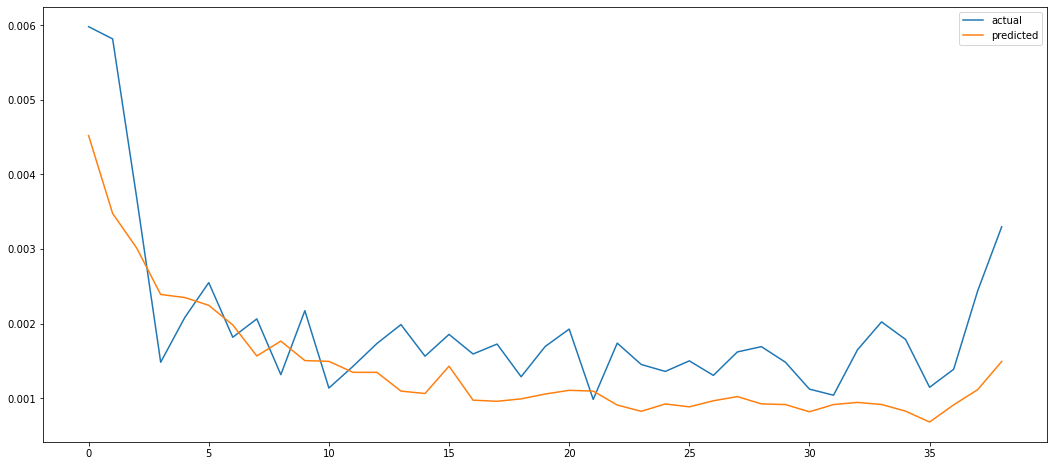

In [274]:
i=30
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(stocks.T[i+20], label="actual")
ax.plot(result, label="predicted")
plt.legend()

In [256]:
# plt.scatter(actual_fourier_window, predicted_fourier_window, alpha=0.5)
# plt.xlabel("actual")
# plt.ylabel("predicted")
# plt.show()

In [257]:
# plt.hist(actual_fourier_window, bins=100)
# plt.show()

In [258]:
# plt.hist(predicted_fourier_window, bins=100)
# plt.show()

In [ ]:
# Sliding window - Adaptive

actual_fourier_window = []
predicted_fourier_window2 = []

for i in range(211):
    stocks_window = stocks[:,i:i+20]
    avg_20day_volatility_window = avg_20day_volatility[i:i+20]    
    fourier_window = flexible_fourier_regression(N=39, di=[], J=2, P=17) # 39 10-minute intervals in each trade day
    res_window = fourier_window.train(stocks_window, avg_20day_volatility_window, 0.0000005)
    print("optimizer success: {}".format(res_window.success))
    print("objective function (mse): {:.8f}".format(res_window.fun))

    # After Bayes
    bayes_dayVol = fourier_window.vol_update(stocks.T[i+20,:39], avg_20day_volatility[i+20], tol=1e-8)
    result = fourier_window.predict(bayes_dayVol)
    
    actual_fourier_window.append(stocks.T[i+20][-1])
    predicted_fourier_window.append(result[-1][0])
    print(i)
    

In [ ]:
print(mean_absolute_error(actual_fourier_window, predicted_fourier_window2))
print(mean_squared_error(actual_fourier_window, predicted_fourier_window2))
print(r2_score(actual_fourier_window, predicted_fourier_window2))

In [275]:
# Sliding window - Adaptive - 2C

volatility_df_window = volatility_df[40:]
volatility_df_window['volatility_fourier_window'] = predicted_fourier_window
volatility_df_window['predicted_fourier_window_before4pm_yest'] = np.array([None] + predicted_fourier_window_before4pm[:-1])
volatility_df_window['volatility_fourier_2c'] = volatility_df_window['daily_volatility_minus4pm']/volatility_df_window['predicted_fourier_window_before4pm_yest']*volatility_df_window['volatility_fourier_window']
predicted_fourier_window3 = np.array(volatility_df_window['volatility_fourier_2c'])



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [276]:
print(mean_absolute_error(actual_fourier_window[1:], predicted_fourier_window3[1:]))
print(mean_squared_error(actual_fourier_window[1:], predicted_fourier_window3[1:]))
print(r2_score(actual_fourier_window[1:], predicted_fourier_window3[1:]))

0.000962161389760493
2.572374617566643e-06
0.10570340144425072


In [ ]:
# ########### FOURIER QQQ ###########

# fourier_qqq = flexible_fourier_regression(N=39, di=[], J=3, P=15) # 39 10-minute intervals in each trade day
# res = fourier.train(stocks200_qqq, avg_20day_volatility200_qqq, 0.0000005)
# print("optimizer success: {}".format(res.success))
# print("objective function (mse): {:.8f}".format(res.fun))

In [ ]:
# n=224
# result = fourier.predict(avg_20day_volatility_qqq[n])

# fig, ax = plt.subplots(1, 1, figsize=(18, 8))
# ax.plot(stocks.T[n], label="actual")
# ax.plot(result, label="predicted")
# plt.xlabel("10 minute Time Interval")
# plt.ylabel("Absolute Log Returns")
# plt.title('Actual vs. Predicted Absolute Log Returns for MSFT on 2021-08-30')
# ax.legend()

In [ ]:
# results_qqq = [None for i in range(20)]
# results_qqq_full = []

# for vol in avg_20day_volatility_qqq:
#     result = fourier_qqq.predict(vol)
#     results_qqq_full.append(np.array([res[0] for res in result]))
#     results_qqq.append(result[-1][0])
# results_qqq = np.array(results_qqq)
# results_qqq_full = np.array(results_qqq_full)

In [ ]:
# # Simple linear regression with Anderson coefficient
# final_df = pd.DataFrame({
#     'Date': dates_final,     
#     'Daily_Volatility': volatility_df['daily_volatility'],
#     'Daily_Volatility_minus4pm': volatility_df['daily_volatility_minus4pm'],

#     'Daily_Volatility_qqq': volatility_df_qqq['daily_volatility'],
#     'Daily_Volatility_qqq_minus4pm': volatility_df_qqq['daily_volatility_minus4pm'],
    
#     'Avg20_Volatility': avg_20day_volatility_raw, 
#     'Avg20_Volatility_qqq': avg_20day_volatility_raw_qqq, 
    
#     'Beta': daily_beta,
#     'Anderson': results,
#     'Anderson_qqq': results_qqq,
#     'Auction_Log_Returns': auction_log_returns
# })